<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/computer_vision/eulerian_magnification/visual_microphone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visual Microphone: passive recovery of sound from video

In [ ]:
!pip install -q pyrtools

In [50]:
import pyrtools as pt
import cv2 as cv
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write 

In [96]:
!wget http://data.csail.mit.edu/vidmag/VisualMic/Results/Plant-2200Hz-Mary_MIDI-input.avi

--2022-10-16 20:15:21--  http://data.csail.mit.edu/vidmag/VisualMic/Results/Plant-2200Hz-Mary_MIDI-input.avi
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13012620288 (12G) [video/x-msvideo]
Saving to: ‘Plant-2200Hz-Mary_MIDI-input.avi’

Plant-2200Hz-Mary_M 100%[===================>]  12.12G   173MB/s    in 79s     

2022-10-16 20:16:40 (157 MB/s) - ‘Plant-2200Hz-Mary_MIDI-input.avi’ saved [13012620288/13012620288]



In [100]:
file = 'Plant-2200Hz-Mary_MIDI-input.avi'
cap = cv.VideoCapture(file)
nframes = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
fps = 2200

In [101]:
def align(x, y):
  tshift = np.argmax(np.convolve(x, np.flip(y)))
  shift = y.size - tshift
  return np.roll(x, shift)

def get_scaled_sound(sound):
  maxs = np.max(sound)
  mins = np.min(sound)
  if maxs != 1.0 or mins != -1.0:
    rangev = maxs - mins
    sound = 2 * sound / rangev
    newmax = np.max(sound)
    offset = newmax - 1.0
    sound -= offset
  return sound

def sound_from_video(nscale, norientation, downsample_factor, sample_rate=2200):
  _, frame = cap.read()     
  if downsample_factor < 1:
    scaled_frame = cv.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
  else:
    scaled_frame = frame
        
  gray_frame = cv.cvtColor(scaled_frame, cv.COLOR_BGR2GRAY)
  norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)

  first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation-1, is_complex=True)
  first_pyr = first_pyr.pyr_coeffs
  first_coeff = dict()
  recovered_signal = dict()
        
  for band, coefficient in first_pyr.items():
    first_coeff[band] = coefficient
    recovered_signal[band] = list()

  time_start = time()
  time_present=time()
        
  for i in range(nframes):
    if downsample_factor < 1:
      frame = cv.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
            
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
    pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
    pyramid = pyramid.pyr_coeffs
    amp_pyr = dict()

    for band, coeff in pyramid.items():
      amp_pyr[band] = abs(coeff)

    phase_diff_pyr = dict()

    for band, coeff in pyramid.items():
      phase_diff_pyr[band] = np.mod(math.pi + np.angle(coeff)-np.angle(first_coeff[band]), 2*math.pi) - math.pi

    for band in pyramid.keys():
      amp = amp_pyr[band]
      phase_diff = phase_diff_pyr[band]
      lms = np.multiply(phase_diff, np.multiply(amp, amp))
      amp_net = np.sum(amp.flatten())
      recovered_signal[band].append(np.mean(lms.flatten()) / amp_net)

    _, frame = cap.read()
    time_present = time()
            
    if i % 500 == 0:
      print("Progress done: " + str(round(i / nframes * 100, 2)) +
            "% after " + str(round(time_present - time_start, 2)) + "s.")
    
  recov_sound = np.zeros(nframes)
  try:
    for rsignal in recovered_signal.values():
      recov_sound += align(np.array(rsignal), np.array(recovered_signal[(0, 0)]))
  except:
    print("error")
        
  sos = signal.butter(3, 0.05, btype='highpass', output='sos')
  filtered_sound = signal.sosfilt(sos, recov_sound)
  filtered_sound = get_scaled_sound(filtered_sound)
  return filtered_sound

In [ ]:
x = sound_from_video(1, 2, 0.1)

In [103]:
x.shape

(38986,)

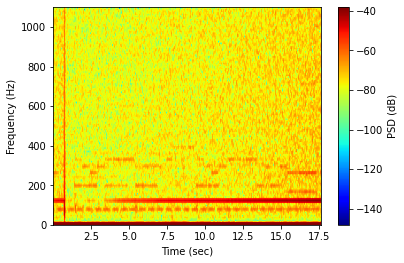

In [121]:
plt.figure()
plt.specgram(x, Fs=2200, cmap=plt.get_cmap('jet'))
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.colorbar().set_label('PSD (dB)')
plt.savefig("spectogram")

In [118]:
write('result.wav', 2200, get_scaled_sound(x))